# Загрузка библиотек и вспомогательные функции

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from enum import Enum
from matplotlib import gridspec
from tqdm.notebook import tqdm

import timm
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/repos_test
if not 'F' in locals():
    %cd src
    from MathUtils import *
    from FileUtils import *
    %cd ../

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/repos_test
/content/gdrive/MyDrive/repos_test/src
/content/gdrive/MyDrive/repos_test


In [ ]:
base_dir = 'data'

# краткие названия полиномов Цернике
titles=['Ast45','Def','Ast0',
        'TreY','ComY','ComX','TreX',
        'TetX','SAstX','SAb3','SAstY','TetY',
        '$Z_{15}$','$Z_{16}$','$Z_{17}$','$Z_{18}$','$Z_{19}$','$Z_{20}$']

class MODE(Enum):
    POS = 0 # за линзой
    NEG = 1 # перед линзой
    BOTH = 2 # с обеих позиций


# БПФ
def faster_F(I):
     return np.array( phase_factor * np.fft.fft2(phase_factor*I)).reshape(I.shape)

# добавление квадратичной фазы к пучку
def Sq_phase(c):
    return np.exp(0.5j*k*c*r_sqr)

# Расчёт комплекской амплитуды в приближении Френеля. d-коэффициенты разложения волнового фронта
# по полиномам Цернике
def prep_sample(A0,d):
    A0_=A0*np.exp(1j*np.sum(Z_matrices*d[:,None,None],axis=0))
    Az=faster_F(A0_)
    Az_abs=np.abs(Az)#Az=np.abs(Az)
    #Az/=np.max(Az)

    Az=crop(Az,center_mean(Az_abs),save_width)
    return Az

# функция для уточнения дефокуса, предсказанного моделью.
# При варьировании значения дефокуса около предсказанного
# минимизируется средневквадратичная разность между экспериментальным
# распределением интенсивности и расчитанным
def compensate_defocus(y_pred, A0_, Az, def_min = -5, def_max = 5, steps = 10):
    uv = np.zeros_like(y_pred)
    uv[1] = 1
    best_def, min_err = 0, 1e10
    for def_ in np.linspace(def_min, def_max, steps):
        tmp = prep_sample(A0_, y_pred + def_ * uv)
        tmp = np.abs(tmp)
        tmp /= np.max(tmp)
        err = np.sum((tmp - Az)**2)

        if err < min_err:
            best_def = def_
            min_err = err
        print(def_)
    y_pred += best_def * uv
    return y_pred, best_def

# Иницализация профиля интенсивности перед линзой и сетки

In [ ]:
# все величиный приведены в мм

# ПЗС-камерa измеряет I = |А|^2
A0_full = read_png(os.path.join(base_dir,'после_телескопа.png'))>>4
Ny,Nx=A0_full.shape
xc,yc=2250,1900

dx_cam=2.4e-3#mm
scale_factor = 300/75
dx_cam*=scale_factor

level=1/np.e
wx,wy=FWHM(A0_full[yc],level),FWHM(A0_full[:,xc],level**2)
print(f'{wx*dx_cam:1.3f}mm x {wy*dx_cam:1.3f} mm')

A0_full=A0_full[:,xc-Ny//2:xc+Ny//2]
xc=Ny//2



# # plt.plot([xc,xc],[0,Ny],'--',c='w')
# # plt.plot([0,Nx],[yc,yc],'--',c='w')

J,I=np.mgrid[0:Ny,0:Ny]
mask=np.exp(-((2*(I-xc)/wx)**2+(2*(J-yc)/(wy))**2)**10)
del I,J

A0_full=A0_full*mask

22.416mm x 24.336 mm


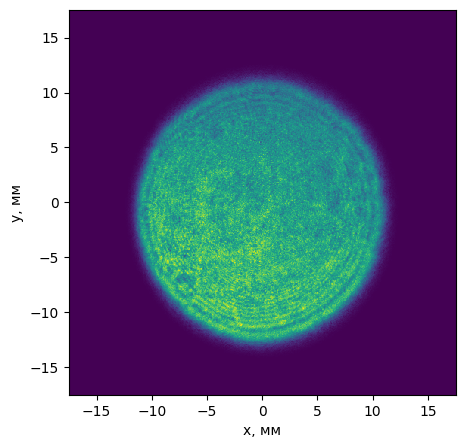

In [ ]:
N=512#*4
Nzeros=0#*3
scale=(N-2*Nzeros)/Ny
A0=zoom(A0_full,scale)
A0=A0*(A0>0)
dx=dx_cam/scale
A0=np.pad(A0,((Nzeros,Nzeros),(Nzeros,Nzeros)))
A0=np.sqrt(A0)
A0=A0[::-1,:]

save_width=184//2
wavelenght=520e-6
k=2*np.pi/wavelenght
ii = np.linspace(0, N - 1, N)
jj = np.linspace(0, N - 1, N)
x,y = np.meshgrid(ii, jj, sparse=True)
phase_factor = np.exp(-1j * np.pi * (x + y))
del x,y,ii,jj

X,Y=np.meshgrid(np.linspace(-N*dx/2,N*dx/2,N),np.linspace(-N*dx/2,N*dx/2,N))
r_sqr=X**2+Y**2


# A0 = SG(X, Y)


D0=20#22#27.54
R=D0/2
m=((2*X/D0)**2+(2*Y/D0)**2)<1
Nz=18
Z_matrices=[Z_OSA[n]*Z_gen(n,X/R,Y/R) for n in range(3,Nz+3)]

unit_m = 1 / (1e3 * k)
# fsize = 20
# ii, jj = np.mgrid[-fsize:fsize, -fsize:fsize]
# Filter = np.exp( - (ii * ii + jj * jj) / (2 * (fsize / 2) ** 2))
# A0 = convolve2d(A0, Filter, mode = 'same')

plt.figure(figsize=(5,5))
plt.pcolormesh(X,Y,A0)
plt.xlabel('x, мм')
plt.ylabel('у, мм');

# Восстановление волнового фронта и проверки

In [ ]:
# порог и среднии вычисленные на обучающей выборке
eps = 1e-2
mean_ds5 = { MODE.POS : 0.1108, MODE.NEG : 0.1246 }
std_ds5 = { MODE.POS : 0.1538, MODE.NEG : 0.1635 }

# принятая при обучении нормировка целевой переменной
norm = np.ones(18) * 1.0
norm[[0,1,2]] = 10
norm[[4,5]] = 7
norm[[9]] = 3

# по данным, с какой позиции будет восстанавливаться ВФ
mode = MODE.POS

filename = (str(mode).split('.')[-1]).lower()
(mean, std) = ([mean_ds5[mode]], [std_ds5[mode]]) if mode != MODE.BOTH\
 else ([mean_ds5[MODE.POS], mean_ds5[MODE.NEG]], [std_ds5[MODE.POS], std_ds5[MODE.NEG]])

In [ ]:
# Загрузка модели

in_chans = 1 if mode != MODE.BOTH else 2
model_name = 'convformer_s18.sail_in22k_ft_in1k'
model_path = f'weights/cof18_ds5{filename}_28k'
model = timm.create_model(model_name, in_chans = in_chans)
model.head.fc.fc2=nn.Linear(in_features = 2048, out_features = 18)
model.load_state_dict(torch.load(model_path, map_location='cpu'))

transform =  SparseNormilize(mean = mean,
                    std = std,
                    eps = eps)

In [ ]:
# фокусное расстояние линзы
f = (37+39.5+61.5)*10
# расстояние до плоскости, в которой снимались картинки за фокусом и перед фокусом
z_pos = f + 102
z_neg = f - 102
# шаги сетки, в этих плоскостях
dxz_neg = z_neg * wavelenght / N / dx
dxz_pos = z_pos * wavelenght / N / dx

# Комплексная амплитуда излучения, для расчёта распределения
# интенсивности на расстоянии z
# перед линзой    : A0
# после линзы     : Al = A0 * Sq_phase(-1/f)
# на расстоянии z : F[ Al Sq_phase(1/z) ]
A0_pos = A0 * Sq_phase(1 / z_pos - 1 / f)
A0_neg = A0 * Sq_phase(1 / z_neg - 1 / f)

In [ ]:
data_path = 'data/WFS_experiment1'
img_path = join(data_path,f'Z3={150}{"_+"}.png')
Az = prepare_exp_image(img_path, dxz_pos, noise = 100, dij = (-0.0 ,0.0),\
                             padding = 300)
# Az = torch.flip(Az, [0, 1])
Az = Az[None, None, :, :]

wfs_data = load_coeffs(join(data_path, 'WFS_data', 'z1_150+.dat'), n = 50) * -1 # смена знака из-за особеннойстей эксперимента

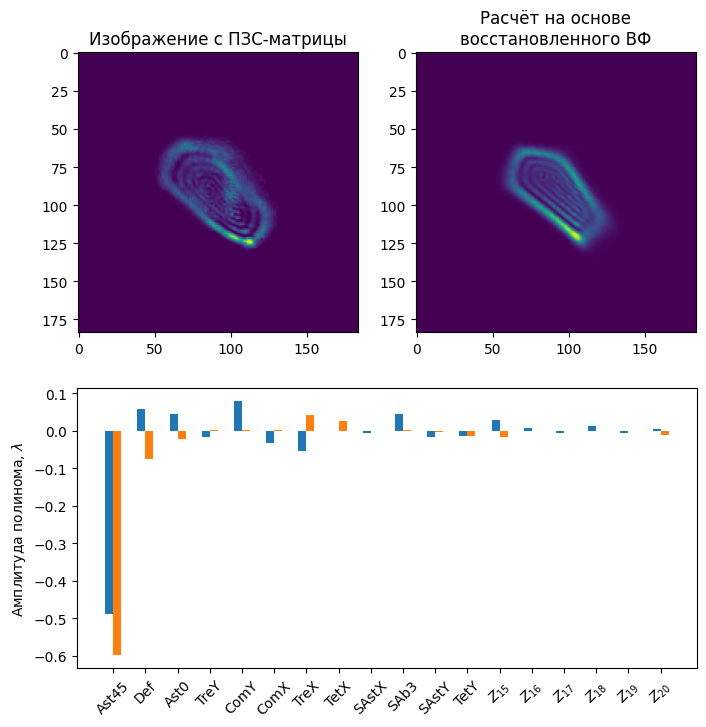

In [ ]:
with torch.no_grad():
    y_pred = model(transform(Az))
    y_pred = y_pred.detach()
    y_pred = y_pred.flatten().tanh()
    y_pred = y_pred * norm
    y_pred = y_pred.numpy()

fig = plt.figure(figsize = (8, 8))
gs = gridspec.GridSpec(1 + in_chans, 2)

ax = plt.subplot(gs[0, 0])
ax.imshow(Az[0, 0] ** 2)
ax.set_title('Изображение с ПЗС-матрицы')

Az_pred = prep_sample(A0_pos, y_pred)
Az_pred = np.abs(Az_pred)
Az_pred /= np.max(Az_pred)

ax = plt.subplot(gs[0, 1])
ax.imshow(Az_pred ** 2)
ax.set_title('Расчёт на основе\nвосстановленного ВФ')

ax = plt.subplot(gs[1, :])
x = np.arange(len(y_pred))
width = 0.25
ax.bar(x - width / 2, y_pred * unit_m / (wavelenght * 1e-3), width = width)
ax.bar(x + width / 2, wfs_data / (wavelenght * 1e-3), width = width)
ax.set_xticks(ticks = x, labels = titles, rotation = 45);
ax.set_ylabel('Амплитуда полинома, $\lambda$');